In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
import torch.optim as optim
import traceback
import numpy as np
from sklearn.metrics import f1_score
import torch.nn as nn
from torchmetrics.functional import f1
from numpy import load
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torch
from numpy import load
import random
# load array
weights = load('weights.npy')
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
import os

def seed_torch(seed=1029):
    random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
seed_torch()
def _init_fn(worker_id):
    np.random.seed(int(seed))

In [3]:
data = pd.read_csv('Fake.csv')
data

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [4]:
# распределение конечно не очень
data.subject.value_counts() * 100 / data.shape[0]

News               38.541800
politics           29.134194
left-news          18.989822
Government News     6.686257
US_News             3.334611
Middle-east         3.313317
Name: subject, dtype: float64

In [5]:
# в статье был только ловеркейс, возьму его (английский все равно нефлективный + всякие апострофы плохо отсекаются)
def process_text(text):
    words = wordpunct_tokenize(text.lower())
    
    return words

In [6]:
data['preprocessed'] = data.text.apply(lambda x: ' '.join(process_text(x)))

In [7]:
cat_mapper = {cat: n for n, cat in enumerate(data.subject.unique())}
cat_mapper

{'News': 0,
 'politics': 1,
 'Government News': 2,
 'left-news': 3,
 'US_News': 4,
 'Middle-east': 5}

In [8]:
data.subject = data.subject.map(cat_mapper)

In [9]:
data = data[['preprocessed', 'subject']]

In [10]:
word2freq = {}
lengths = []

for text in tqdm(data.preprocessed):
    words = text.split(' ')
    lengths.append(len(words))
    
    for word in words:
        if word in word2freq:
            word2freq[word] += 1
        else:
            word2freq[word] = 1

100%|██████████████████████████████████████████████████████████████████████████| 23481/23481 [00:03<00:00, 6953.19it/s]


C:\Users\trekc\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Распределение длин слов в текстах'}, xlabel='Длина предложения', ylabel='Доля'>

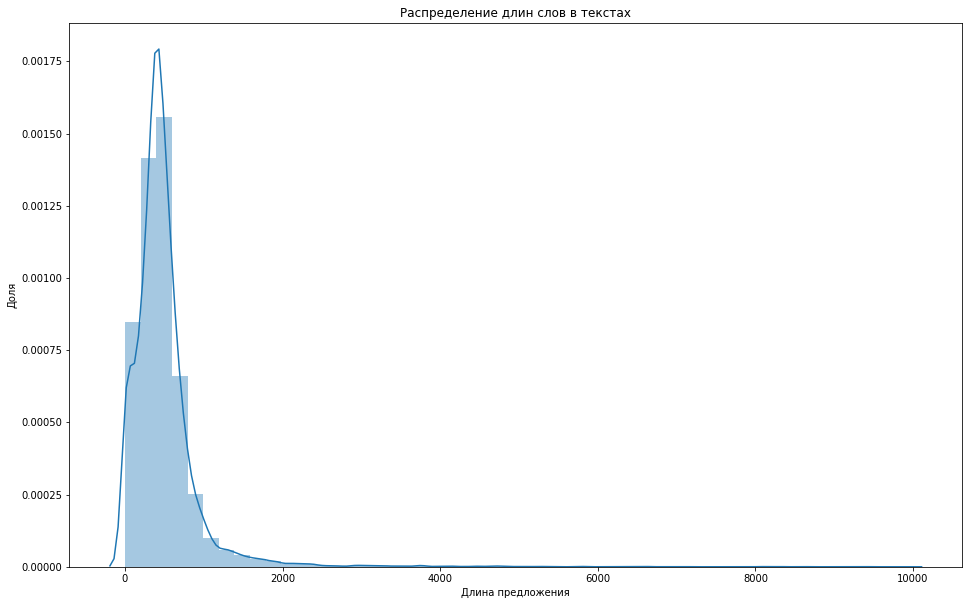

In [11]:
plt.figure(figsize=(16, 10))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина предложения')
plt.ylabel('Доля')
sns.distplot(lengths)

In [12]:
# не вижу смысла бить тексты по длине, их не так много + много близких к этой длине + пусть учиться уже на 1к слов все делать
upper_threshold = 1024
lower_threshold = 0

correct_percent = len([sent_len for sent_len in lengths 
                       if sent_len <= upper_threshold and sent_len >= lower_threshold]) * 100 / len(lengths)

'{:.2f} % наших текстов входят в промежуток от {} до {} слов'.format(correct_percent, lower_threshold, upper_threshold)

'94.32 % наших текстов входят в промежуток от 0 до 1024 слов'

In [13]:
for i, text in enumerate(data.preprocessed):
    if len(text.split()) == 0:
        data = data.drop([i])

In [14]:
train_sentences, val_sentences = train_test_split(data, test_size=0.2)

In [15]:
vocab = Counter()

for text in data.preprocessed:
    vocab.update(text.split())
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 95413


In [16]:
# Добавлю фильтр по словам, можно и не делать его
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 5 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 5 раз: 33316


In [17]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [18]:
id2word = {i:word for word, i in word2id.items()}

In [85]:
class NewsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['preprocessed'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.LongTensor(dataset['subject'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        tokens = self.dataset[index].split()
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
        ids, y = list(zip(*batch))
        
        ids = list(ids)
        for i, id in enumerate(ids):
            ids[i] = F.pad(torch.LongTensor(id), (0, 1024-len(ids[i])))

        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)

        y = torch.LongTensor(y).to(self.device).squeeze() 
        return padded_ids, y

In [86]:
train_dataset = NewsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=256, worker_init_fn=_init_fn)
#batch = next(iter(train_iterator))

In [87]:
val_dataset = NewsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=256, worker_init_fn=_init_fn)

In [40]:
from gensim import models

def get_weights(path2model):
    w = models.KeyedVectors.load_word2vec_format(
        'GoogleNews-vectors-negative300.bin', binary=True)

    weights = np.zeros((len(word2id), 300))
    count = 0
    for word, i in word2id.items():
        if word == 'PAD':
            continue   
        try:
            weights[i] = w[word]    
        except KeyError:
            count += 1
            weights[i] = np.random.uniform(-0.25,0.25,300)
    
    return weights

In [22]:
# from numpy import asarray
# from numpy import save

# save('weights.npy', weights)

In [22]:
class C_LSTM(nn.Module):
    
    def __init__(self, weights, lstm_size, out_conv):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.Tensor(weights), freeze=False)
        self.bigrams = nn.Conv1d(in_channels=weights.shape[1], out_channels=out_conv, kernel_size=3)
        self.relu = nn.ReLU()
        
        self.LSTM = nn.LSTM(input_size=out_conv, hidden_size=lstm_size,
                          num_layers=1, batch_first=True)
        
        self.hidden = nn.Linear(in_features=lstm_size, out_features=6)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        #batch_size x n_channels x seq_length
        feature_map_bigrams = self.relu(self.bigrams(self.dropout(embedded)))
        #batch_size x n_channels x seq_length
        x, _ = self.LSTM(feature_map_bigrams.transpose(1, 2))
        h_s, c_s = _[0], _[1]

        logits = self.hidden(self.dropout(h_s.transpose(0, 1).squeeze()))
        
        return logits

In [23]:
def train(model, iterator, optimizer, criterion):
#     print(next(model.parameters()))
    epoch_loss = 0
    model.train()
    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        preds = model(texts)
        loss = criterion(preds, ys) 
        loss.backward() 
        optimizer.step()
        epoch_loss += loss.item()
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}') 
#     print(next(model.parameters()))

    return model, epoch_loss / len(iterator) 

In [24]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds, ys, average='micro', num_classes=6)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/(i+1)}, Val f1: {epoch_metric/(i+1)}')

    return model, epoch_metric / len(iterator), epoch_loss / len(iterator) 

In [25]:
def learning(n_epochs, model, optimizer, criterion, losses, losses_eval, f1s, f1s_eval):
    for i in range(n_epochs):
        print(f'\nstarting Epoch {i}')
        print('Training...')
        model, epoch_loss = train(model, train_iterator, optimizer, criterion)
        losses.append(epoch_loss)
        print('\nEvaluating on train...')
        model, f1_on_train, _ = evaluate(model, train_iterator, criterion)
        f1s.append(f1_on_train.cpu())
        print('\nEvaluating on test...')
        model, f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
        losses_eval.append(epoch_loss_on_test)
        f1s_eval.append(f1_on_test.cpu())
    
    return losses, losses_eval, f1s, f1s_eval

In [26]:
def plot_error(losses, losses_eval):
    plt.plot(losses)
    plt.plot(losses_eval)
    plt.title('CE loss value')
    plt.ylabel('CE loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [27]:
def plot_f1(f1s, f1s_eval):
    plt.plot(f1s)
    plt.plot(f1s_eval)
    plt.title('f1 value')
    plt.ylabel('f1 value')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

### Я сначала реализую чисто модель из статьи, а дальше буду делать кастом пайплайн


starting Epoch 0
Training...
Train loss: 2.088327251947843
Train loss: 1.75256699985928
Train loss: 1.654232158893492
Train loss: 1.599381184577942
Train loss: 1.5678021510442097

Evaluating on train...
Val loss: 1.42056576694761, Val f1: 0.4048549234867096
Val loss: 1.4258811644145422, Val f1: 0.4100167453289032
Val loss: 1.4272773805118741, Val f1: 0.4080171287059784
Val loss: 1.4246854249920164, Val f1: 0.4065987765789032
Val loss: 1.4265847717012679, Val f1: 0.40619421005249023

Evaluating on test...
Val loss: 1.411208709081014, Val f1: 0.4166666865348816
Val loss: 1.410086731115977, Val f1: 0.4231770932674408
Val loss: 1.417748424741957, Val f1: 0.4249131977558136
Val loss: 1.4269464413324993, Val f1: 0.4143880307674408
Val loss: 1.4226940155029297, Val f1: 0.41588544845581055
Val loss: 1.4287606279055278, Val f1: 0.4112522304058075

starting Epoch 1
Training...
Train loss: 1.539885319196261
Train loss: 1.4883902779331915
Train loss: 1.473489563639571
Train loss: 1.45820143873041

Val loss: 1.4161320328712463, Val f1: 0.419921875
Val loss: 1.4226584566964044, Val f1: 0.421440988779068
Val loss: 1.4307450552781422, Val f1: 0.4111328125
Val loss: 1.4269898494084676, Val f1: 0.4127604365348816
Val loss: 1.4328164723184373, Val f1: 0.4085747301578522

starting Epoch 10
Training...
Train loss: 1.5528679994436412
Train loss: 1.4873570601145427
Train loss: 1.467330176655839
Train loss: 1.4581631357019598
Train loss: 1.4496361552805141

Evaluating on train...
Val loss: 1.4199264645576477, Val f1: 0.4048549234867096
Val loss: 1.4219771112714494, Val f1: 0.4089006781578064
Val loss: 1.4244446385474432, Val f1: 0.4074590802192688
Val loss: 1.427190010036741, Val f1: 0.407017320394516
Val loss: 1.426486885547638, Val f1: 0.40731027722358704

Evaluating on test...
Val loss: 1.4170326391855876, Val f1: 0.4153645932674408
Val loss: 1.4126399755477905, Val f1: 0.4225260615348816
Val loss: 1.4204979870054457, Val f1: 0.4244791567325592
Val loss: 1.430109163125356, Val f1: 0.4140

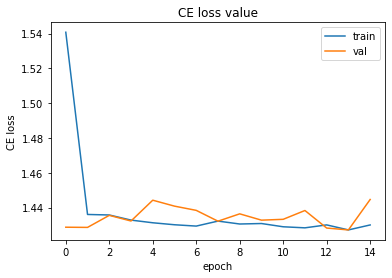

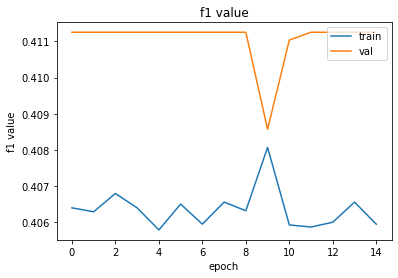

In [29]:
try:
    model = C_LSTM(weights, lstm_size=150, out_conv=150)
    optimizer = optim.RMSprop(model.parameters(), lr=0.005, weight_decay=0.001)
    criterion = nn.CrossEntropyLoss() # 
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    losses = []
    losses_eval = []
    f1s = []
    f1s_eval = []

    losses, losses_eval, f1s, f1s_eval = learning(15, model, optimizer, criterion, losses, losses_eval, f1s, f1s_eval)
    
    plot_error(losses, losses_eval)
    plot_f1(f1s, f1s_eval)
    
    del model, optimizer, criterion
    torch.cuda.empty_cache()
    
except Exception or KeyboardInterrupt:
    traceback.print_exc()
    del model, optimizer, criterion
    torch.cuda.empty_cache()

# С другими параметрами слоев


starting Epoch 0
Training...
Train loss: 3.9992428834621725
Train loss: 2.7847968339920044
Train loss: 2.363057511608775
Train loss: 2.148146557807922
Train loss: 2.01361758639847

Evaluating on train...
Val loss: 1.5006760273660933, Val f1: 0.3858817219734192
Val loss: 1.4776588678359985, Val f1: 0.4048549234867096
Val loss: 1.478820528302874, Val f1: 0.4072730839252472
Val loss: 1.4790721791131156, Val f1: 0.4038783609867096
Val loss: 1.4762977140290396, Val f1: 0.40630581974983215

Evaluating on test...
Val loss: 1.4713823795318604, Val f1: 0.4166666865348816
Val loss: 1.4602588613828023, Val f1: 0.4231770932674408
Val loss: 1.4706405401229858, Val f1: 0.425347238779068
Val loss: 1.481234351793925, Val f1: 0.4150390625
Val loss: 1.4795347770055136, Val f1: 0.4164062738418579
Val loss: 1.4851460258165996, Val f1: 0.4116862714290619

starting Epoch 1
Training...
Train loss: 1.6069789941494281
Train loss: 1.514763319933856
Train loss: 1.4884409293895815
Train loss: 1.4774063132025979


Val loss: 1.416212300459544, Val f1: 0.4231770932674408
Val loss: 1.421201467514038, Val f1: 0.4249131977558136
Val loss: 1.4300736983617146, Val f1: 0.4143880307674408
Val loss: 1.4250723044077556, Val f1: 0.41588544845581055
Val loss: 1.4310704072316487, Val f1: 0.4112522304058075

starting Epoch 10
Training...
Train loss: 1.5341218618246226
Train loss: 1.4817564266699332
Train loss: 1.4637320826693279
Train loss: 1.457967285676436
Train loss: 1.4543082247609678

Evaluating on train...
Val loss: 1.4384957807404655, Val f1: 0.4087611734867096
Val loss: 1.4525663214070457, Val f1: 0.4061104953289032
Val loss: 1.445572404634385, Val f1: 0.4040178656578064
Val loss: 1.4430957372699464, Val f1: 0.4035295844078064
Val loss: 1.4373815928186688, Val f1: 0.4061383903026581

Evaluating on test...
Val loss: 1.4271631240844727, Val f1: 0.4166666865348816
Val loss: 1.4269958138465881, Val f1: 0.4231770932674408
Val loss: 1.4320361614227295, Val f1: 0.4249131977558136
Val loss: 1.4391162395477295,

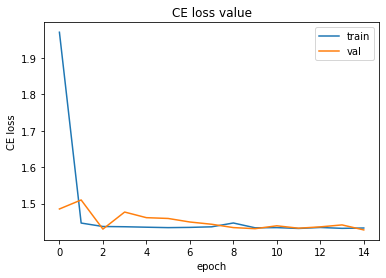

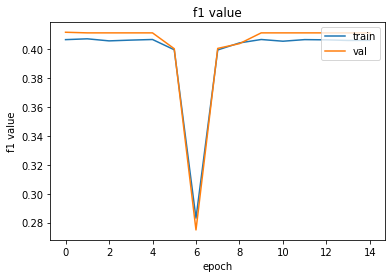

In [30]:
try:
    model = C_LSTM(weights, lstm_size=300, out_conv=300)
    optimizer = optim.RMSprop(model.parameters(), lr=0.005, weight_decay=0.001)
    criterion = nn.CrossEntropyLoss() # 
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    losses = []
    losses_eval = []
    f1s = []
    f1s_eval = []

    losses, losses_eval, f1s, f1s_eval = learning(15, model, optimizer, criterion, losses, losses_eval, f1s, f1s_eval)
    
    plot_error(losses, losses_eval)
    plot_f1(f1s, f1s_eval)
    
    del model, optimizer, criterion
    torch.cuda.empty_cache()
    
except Exception or KeyboardInterrupt:
    traceback.print_exc()
    del model, optimizer, criterion
    torch.cuda.empty_cache()

### Эээксперименты

In [93]:
class C_LSTM_exp(nn.Module):
    
    def __init__(self, weights, params):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.Tensor(weights), freeze=False)
        
        self.conv2 = nn.Conv1d(in_channels=weights.shape[1], out_channels=params['out_conv'], kernel_size=2)
        self.conv3 = nn.Conv1d(in_channels=weights.shape[1], out_channels=params['out_conv'], kernel_size=3)
        self.conv4 = nn.Conv1d(in_channels=weights.shape[1], out_channels=params['out_conv'], kernel_size=4)
        
        self.relu = nn.ReLU()
        
        if params['multiple_conv_layers']:
            self.LSTM = nn.LSTM(input_size=len(params['multiple_kernel'])*params['out_conv'], 
                                hidden_size=params['lstm_size'], num_layers=1, batch_first=True)
        else:
            self.LSTM = nn.LSTM(input_size=params['out_conv'], hidden_size=params['lstm_size'],
                              num_layers=1, batch_first=True)        
        
        self.hidden = nn.Linear(in_features=params['lstm_size'], out_features=6)
        self.dropout = nn.Dropout(p=params['dropout_rate'])


    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        #batch_size x n_channels x seq_length
        if params['emb_dropout']:
            embedded = self.dropout(embedded)
            
        #batch_size x n_channels x seq_length
        if params['multiple_conv_layers']:
            len_layers = []
            fm2_flag = False
            fm3_flag = False
            fm4_flag = False
            
            if 2 in params['multiple_kernel']:
                fm2 = self.relu(self.conv2(embedded))
                fm2_flag = True
                len_layers.append(fm2)
            if 3 in params['multiple_kernel']:
                fm3 = self.relu(self.conv3(embedded))
                fm3_flag = True
                len_layers.append(fm3)
            if 4 in params['multiple_kernel']:
                fm4 = self.relu(self.conv4(embedded))
                fm4_flag = True
                len_layers.append(fm4)
            
            if fm2_flag == True and fm3_flag == True:
                min_cut = min(fm2.shape[2], fm3.shape[2]) 
            if fm2_flag == True and fm4_flag == True:
                min_cut = min(fm2.shape[2], fm4.shape[2]) 
            elif fm3_flag == True and fm4_flag == True:
                min_cut = min(fm3.shape[2], fm4.shape[2])
            elif fm2_flag == True and fm3_flag == True and fm4_flag == True:
                min_cut = min(fm2.shape[2], fm3.shape[2], fm4.shape[2])
                
            try:
                c_feature_map = torch.cat((len_layers[0][:,:,:min_cut], len_layers[1][:,:,:min_cut], len_layers[2][:,:,:min_cut]), 1)
            except IndexError:
                c_feature_map = torch.cat((len_layers[0][:,:,:min_cut], len_layers[1][:,:,:min_cut]), 1)
            
            x, _ = self.LSTM(c_feature_map.transpose(1, 2))
        
        else:
            if params['single_kernel'] == 2:
                fm = self.relu(self.conv2(embedded))
            if params['single_kernel'] == 3:
                fm = self.relu(self.conv3(embedded))
            if params['single_kernel'] == 4:
                fm = self.relu(self.conv4(embedded))                
            x, _ = self.LSTM(fm.transpose(1, 2))
            
        h_s, c_s = _[0], _[1]
        
        if params['lstm_output_dropout']:
            h_s = self.dropout(h_s)
        
        logits = self.hidden(h_s.transpose(0, 1).squeeze())

        return logits

Я не нашел в статье описание разных мест для регуляризации и паддингов

In [83]:
params={
    'lstm_size': int,
    'out_conv': int,
    'dropout_rate': float,
    '2_conv_layers': False,
    'emb_dropout': False,
    'lstm_output_dropout': False,
    'single_kernel': int,
    'multiple_kernel': list,
    'weight_decay': float,
    'l_r': float,
    'n_epochs': int,
    'path2weights': False,
}

In [82]:
def play_exp(params):
    try:
        if params['path2weights']:
            weights = get_weights(params['path2weights'])
        else:
            weights = load('weights.npy')
        
        model = C_LSTM_exp(weights, params)
        optimizer = optim.RMSprop(model.parameters(), lr = params['l_r'], weight_decay = params['weight_decay'])
        criterion = nn.CrossEntropyLoss() # 
        model = model.to(DEVICE)
        criterion = criterion.to(DEVICE)

        losses = []
        losses_eval = []
        f1s = []
        f1s_eval = []

        losses, losses_eval, f1s, f1s_eval = learning(params['n_epochs'], model, optimizer, criterion, losses, losses_eval, f1s, f1s_eval)
        plot_error(losses, losses_eval)
        plot_f1(f1s, f1s_eval)
        del model, optimizer, criterion
        torch.cuda.empty_cache()

    except Exception or KeyboardInterrupt:
        plot_error(losses, losses_eval)
        plot_f1(f1s, f1s_eval)
        traceback.print_exc()
        del model, optimizer, criterion
        torch.cuda.empty_cache()

Логика моих экспериментов такая. Так как устраивать полный гридсерч нереально, я попробую отобрать лучшие параметры для стоковой модели из статьи, а дальше попробую подобрать количество слоев и их параметры


starting Epoch 0
Training...
Train loss: 1.8887320023316603
Train loss: 1.6772441334194608
Train loss: 1.596489182332667
Train loss: 1.5625492160970516
Train loss: 1.5434518309607022

Evaluating on train...
Val loss: 1.429918578692845, Val f1: 0.4031808078289032
Val loss: 1.4408240275723594, Val f1: 0.4030413031578064
Val loss: 1.4450151863552274, Val f1: 0.4002046287059784
Val loss: 1.4428047559091024, Val f1: 0.4022042453289032
Val loss: 1.4427778039659773, Val f1: 0.4012276828289032

Evaluating on test...
Val loss: 1.4311768213907878, Val f1: 0.4114583432674408
Val loss: 1.4323384563128154, Val f1: 0.4212239682674408
Val loss: 1.4393694400787354, Val f1: 0.4197048544883728
Val loss: 1.4472601612408955, Val f1: 0.4078776240348816
Val loss: 1.4414323488871257, Val f1: 0.4098958671092987
Val loss: 1.4460942414071825, Val f1: 0.4055365324020386

starting Epoch 1
Training...
Train loss: 1.5620787877302904
Train loss: 1.4903034943121451
Train loss: 1.4723950624465942
Train loss: 1.463265

Val loss: 1.405173076523675, Val f1: 0.4283854067325592
Val loss: 1.4156462848186493, Val f1: 0.41796875
Val loss: 1.4138185580571492, Val f1: 0.4192708432674408
Val loss: 1.419991393884023, Val f1: 0.4154488146305084

starting Epoch 10
Training...
Train loss: 1.5007033439782949
Train loss: 1.443354226924755
Train loss: 1.4257550414015607
Train loss: 1.4197329911318692
Train loss: 1.4135102551916372

Evaluating on train...
Val loss: 1.3891958594322205, Val f1: 0.4176897406578064
Val loss: 1.383090764284134, Val f1: 0.4160156548023224
Val loss: 1.382123589515686, Val f1: 0.419921875
Val loss: 1.3836046648877007, Val f1: 0.4189453423023224
Val loss: 1.3822098391396658, Val f1: 0.4191964268684387

Evaluating on test...
Val loss: 1.4100531737009685, Val f1: 0.4153645932674408
Val loss: 1.4032587210337322, Val f1: 0.4231770932674408
Val loss: 1.4035286506017048, Val f1: 0.4266493022441864
Val loss: 1.4144311447938283, Val f1: 0.4156901240348816
Val loss: 1.4143086353937784, Val f1: 0.416145

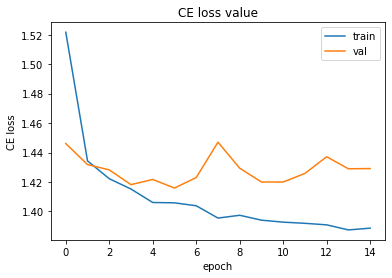

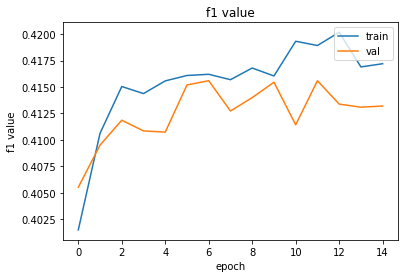

In [40]:
params['lstm_size'] = 150
params['out_conv'] = 150
params['dropout_rate'] = 0.5
params['multiple_conv_layers'] = False
params['emb_dropout'] = True
params['lstm_output_dropout'] = True
params['single_kernel'] = 3
params['multiple_kernel'] = [2, 3, 4]
params['weight_decay'] = 0.0001
params['l_r'] = 0.005
params['n_epochs'] = 15
params['path2weights'] = False

play_exp(params)

Уменьшу дропаут


starting Epoch 0
Training...
Train loss: 2.6523947440660915
Train loss: 2.106576336754693
Train loss: 1.8601468685196667
Train loss: 1.7174124565991489
Train loss: 1.624885790589927

Evaluating on train...
Val loss: 1.2243859257016863, Val f1: 0.5521763563156128
Val loss: 1.2267433404922485, Val f1: 0.5518973469734192
Val loss: 1.234866508415767, Val f1: 0.5493861436843872
Val loss: 1.2310856516872133, Val f1: 0.5520368814468384
Val loss: 1.2295733179364885, Val f1: 0.5573102831840515

Evaluating on test...
Val loss: 1.2151991526285808, Val f1: 0.58203125
Val loss: 1.2256880799929302, Val f1: 0.572265625
Val loss: 1.2334536976284451, Val f1: 0.573350727558136
Val loss: 1.2364914913972218, Val f1: 0.5638021230697632
Val loss: 1.2323772350947062, Val f1: 0.5682291984558105
Val loss: 1.2381660872035556, Val f1: 0.5610769987106323

starting Epoch 1
Training...
Train loss: 1.336179962525001
Train loss: 1.2265860195513125
Train loss: 1.1614318271962607
Train loss: 1.1312248490073464
Train l

Val loss: 0.6335046887397766, Val f1: 0.6940104365348816
Val loss: 0.6475781599680582, Val f1: 0.6901041865348816
Val loss: 0.6455753604571025, Val f1: 0.6872396469116211
Val loss: 0.6529907849099901, Val f1: 0.6861681938171387

starting Epoch 10
Training...
Train loss: 0.6692327581919156
Train loss: 0.6546855590961598
Train loss: 0.6425174896310015
Train loss: 0.6422351360321045
Train loss: 0.6417249743489252

Evaluating on train...
Val loss: 0.5881090462207794, Val f1: 0.7053571939468384
Val loss: 0.5995515925543649, Val f1: 0.7034040689468384
Val loss: 0.5899676552840641, Val f1: 0.7076823115348816
Val loss: 0.595424340239593, Val f1: 0.7054966688156128
Val loss: 0.5964191964694432, Val f1: 0.7035714387893677

Evaluating on test...
Val loss: 0.6463749210039774, Val f1: 0.6796875
Val loss: 0.6244007249673208, Val f1: 0.6979166865348816
Val loss: 0.6333055032624139, Val f1: 0.6935763955116272
Val loss: 0.6498057891925176, Val f1: 0.689453125
Val loss: 0.6463674545288086, Val f1: 0.686

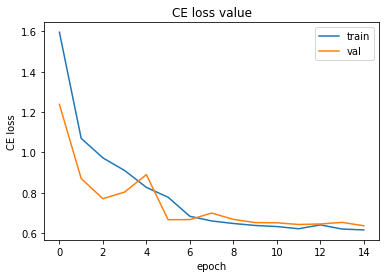

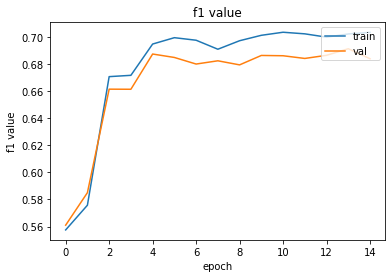

In [39]:
params['lstm_size'] = 150
params['out_conv'] = 150
params['dropout_rate'] = 0.25
params['multiple_conv_layers'] = False
params['emb_dropout'] = True
params['lstm_output_dropout'] = True
params['single_kernel'] = 3
params['multiple_kernel'] = [2, 3, 4]
params['weight_decay'] = 0.0001
params['l_r'] = 0.01
params['n_epochs'] = 15
params['path2weights'] = False

play_exp(params)

Уберу один дропаут -> хуже


starting Epoch 0
Training...
Train loss: 2.395460532261775
Train loss: 1.9483064413070679
Train loss: 1.7941249550842657
Train loss: 1.70845619765195
Train loss: 1.6453123507292375

Evaluating on train...
Val loss: 1.3669851337160384, Val f1: 0.4302455484867096
Val loss: 1.3633883850915092, Val f1: 0.4356864094734192
Val loss: 1.3653610490617298, Val f1: 0.435546875
Val loss: 1.3695575296878815, Val f1: 0.437290757894516
Val loss: 1.370452983038766, Val f1: 0.43939733505249023

Evaluating on test...
Val loss: 1.3573572635650635, Val f1: 0.4596354365348816
Val loss: 1.3664891918500264, Val f1: 0.4563802182674408
Val loss: 1.3760812547471788, Val f1: 0.444878488779068
Val loss: 1.3800041476885478, Val f1: 0.4384765625
Val loss: 1.3732234001159669, Val f1: 0.4427083432674408
Val loss: 1.378369218773312, Val f1: 0.43667951226234436

starting Epoch 1
Training...
Train loss: 1.373454524920537
Train loss: 1.2862939393078838
Train loss: 1.2242128965331287
Train loss: 1.214324868809093
Train l

Val loss: 0.6353504657745361, Val f1: 0.7018229365348816
Val loss: 0.645928238828977, Val f1: 0.6966146230697632
Val loss: 0.6452173550923666, Val f1: 0.6942708492279053
Val loss: 0.6529471443759071, Val f1: 0.6944880485534668

starting Epoch 10
Training...
Train loss: 0.6446587328727429
Train loss: 0.6351441928633937
Train loss: 0.6247846215236478
Train loss: 0.6220392893661152
Train loss: 0.6216885710971943

Evaluating on train...
Val loss: 0.5746162150587354, Val f1: 0.7003348469734192
Val loss: 0.5703371848378863, Val f1: 0.7015904188156128
Val loss: 0.5741589353198097, Val f1: 0.7020089626312256
Val loss: 0.5696939900517464, Val f1: 0.7058454751968384
Val loss: 0.5672323725053242, Val f1: 0.707812488079071

Evaluating on test...
Val loss: 0.6378442247708639, Val f1: 0.6848958730697632
Val loss: 0.6090117494265238, Val f1: 0.7018229365348816
Val loss: 0.6169810560014513, Val f1: 0.6961805820465088
Val loss: 0.6283214489618937, Val f1: 0.6923828125
Val loss: 0.6253467559814453, Val 

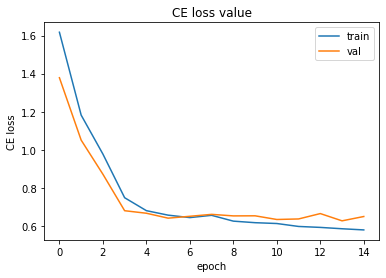

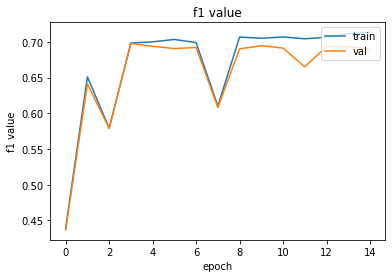

In [37]:
params['lstm_size'] = 150
params['out_conv'] = 150
params['dropout_rate'] = 0.25
params['multiple_conv_layers'] = False
params['emb_dropout'] = False
params['lstm_output_dropout'] = True
params['single_kernel'] = 2
params['multiple_kernel'] = [2, 3, 4]
params['weight_decay'] = 0.0001
params['l_r'] = 0.01
params['n_epochs'] = 15
params['path2weights'] = False

play_exp(params)

Уберу другой дропаут -> хуже


starting Epoch 0
Training...
Train loss: 1.957971847974337
Train loss: 1.6927088719827157
Train loss: 1.5993823888825207
Train loss: 1.5693749644539572
Train loss: 1.5429382168728372

Evaluating on train...
Val loss: 1.422634482383728, Val f1: 0.4012276828289032
Val loss: 1.4340452935014452, Val f1: 0.3971819281578064
Val loss: 1.4337692090443201, Val f1: 0.3968563973903656
Val loss: 1.4294848484652383, Val f1: 0.3997628390789032
Val loss: 1.4274581142834255, Val f1: 0.4026227593421936

Evaluating on test...
Val loss: 1.4252938429514568, Val f1: 0.40234375
Val loss: 1.418876588344574, Val f1: 0.4166666865348816
Val loss: 1.427717235353258, Val f1: 0.4166666567325592
Val loss: 1.4391806622346242, Val f1: 0.404296875
Val loss: 1.4329986969629924, Val f1: 0.40572917461395264
Val loss: 1.4376365145047505, Val f1: 0.40231797099113464

starting Epoch 1
Training...
Train loss: 1.5188840811069195
Train loss: 1.4792358522061948
Train loss: 1.4556997171262416
Train loss: 1.4534334096041592
Trai

Val loss: 0.6788516143957773, Val f1: 0.6881510615348816
Val loss: 0.6863222453329298, Val f1: 0.6818576455116272
Val loss: 0.7007495661576589, Val f1: 0.6764323115348816
Val loss: 0.6961368401845296, Val f1: 0.6734375357627869
Val loss: 0.7028737233744727, Val f1: 0.6723863482475281

starting Epoch 10
Training...
Train loss: 0.6666200573627765
Train loss: 0.6362749029088903
Train loss: 0.6215220995065642
Train loss: 0.6165136098861694
Train loss: 0.6126070013944653

Evaluating on train...
Val loss: 0.5741069103990283, Val f1: 0.707589328289032
Val loss: 0.5762777413640704, Val f1: 0.7070313096046448
Val loss: 0.577152689297994, Val f1: 0.705450177192688
Val loss: 0.5765559822320938, Val f1: 0.7054966688156128
Val loss: 0.5775429495743343, Val f1: 0.7041294574737549

Evaluating on test...
Val loss: 0.6262355248133341, Val f1: 0.6927083730697632
Val loss: 0.6009168326854706, Val f1: 0.7083333730697632
Val loss: 0.6081749465730455, Val f1: 0.7039930820465088
Val loss: 0.6198372542858124,

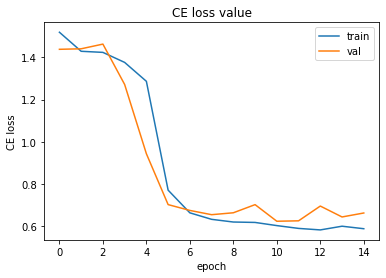

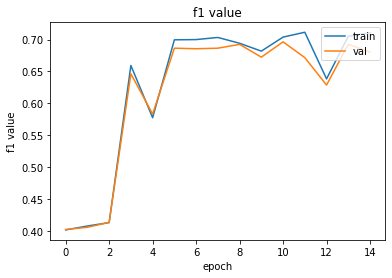

In [38]:
params['lstm_size'] = 150
params['out_conv'] = 150
params['dropout_rate'] = 0.25
params['multiple_conv_layers'] = False
params['emb_dropout'] = False
params['lstm_output_dropout'] = False
params['single_kernel'] = 2
params['multiple_kernel'] = [2, 3, 4]
params['weight_decay'] = 0.0001
params['l_r'] = 0.01
params['n_epochs'] = 15
params['path2weights'] = False

play_exp(params)

Верну дропаут, поменяю кернел на 2 -> хуже


starting Epoch 0
Training...
Train loss: 2.2139915319589467
Train loss: 1.8602579213954784
Train loss: 1.742249392881626
Train loss: 1.6808008865876631
Train loss: 1.6380131434703218

Evaluating on train...
Val loss: 1.2894298349108015, Val f1: 0.6595982313156128
Val loss: 1.2893972907747542, Val f1: 0.6563895344734192
Val loss: 1.2859126301038832, Val f1: 0.6575521230697632
Val loss: 1.286896452307701, Val f1: 0.6560407876968384
Val loss: 1.292892839227404, Val f1: 0.6549107432365417

Evaluating on test...
Val loss: 1.2839008172353108, Val f1: 0.6588541865348816
Val loss: 1.2862925132115681, Val f1: 0.666015625
Val loss: 1.2936390373441908, Val f1: 0.65625
Val loss: 1.300460954507192, Val f1: 0.6526693105697632
Val loss: 1.2967401107152303, Val f1: 0.6481771469116211
Val loss: 1.3025928205913968, Val f1: 0.6467390656471252

starting Epoch 1
Training...
Train loss: 1.3060648074516883
Train loss: 1.2456174625290766
Train loss: 1.1634189966248303
Train loss: 1.0961790225722574
Train los

Val loss: 0.6503506104151408, Val f1: 0.6865234375
Val loss: 0.6458542267481486, Val f1: 0.6846354603767395
Val loss: 0.6478782693545023, Val f1: 0.6842883825302124

starting Epoch 10
Training...
Train loss: 0.6522368100973276
Train loss: 0.6326684708948489
Train loss: 0.6265524378636989
Train loss: 0.623464577848261
Train loss: 0.6240506785503332

Evaluating on train...
Val loss: 0.6121722757816315, Val f1: 0.6964285969734192
Val loss: 0.6105602192027229, Val f1: 0.6986607313156128
Val loss: 0.6093687755720956, Val f1: 0.697265625
Val loss: 0.6078389286994934, Val f1: 0.7004045844078064
Val loss: 0.6085754649979728, Val f1: 0.6974888443946838

Evaluating on test...
Val loss: 0.6498379309972128, Val f1: 0.6888021230697632
Val loss: 0.6349603335062662, Val f1: 0.7024739980697632
Val loss: 0.6371411879857382, Val f1: 0.6987847089767456
Val loss: 0.6502346197764078, Val f1: 0.6943359375
Val loss: 0.6547247489293416, Val f1: 0.690625011920929
Val loss: 0.6579453812705146, Val f1: 0.6905817

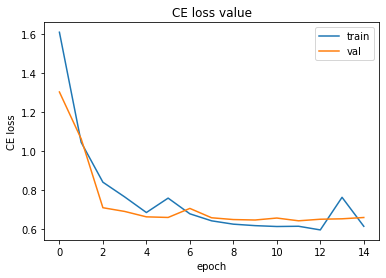

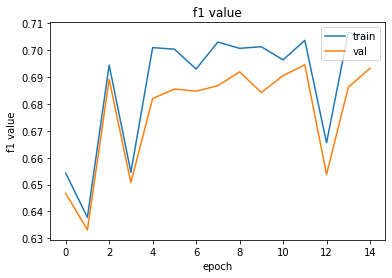

In [41]:
params['lstm_size'] = 150
params['out_conv'] = 150
params['dropout_rate'] = 0.25
params['multiple_conv_layers'] = False
params['emb_dropout'] = True
params['lstm_output_dropout'] = True
params['single_kernel'] = 2
params['multiple_kernel'] = [2, 3, 4]
params['weight_decay'] = 0.0001
params['l_r'] = 0.01
params['n_epochs'] = 15
params['path2weights'] = False

play_exp(params)

Добавлю фильтров. Наверное это лучший результат


starting Epoch 0
Training...
Train loss: 3.6481903057831984
Train loss: 2.79827822137762
Train loss: 2.4389140460549332
Train loss: 2.232845768061551
Train loss: 2.09957116064818

Evaluating on train...
Val loss: 1.5502610121454512, Val f1: 0.2837611734867096
Val loss: 1.550950390951974, Val f1: 0.2901785969734192
Val loss: 1.5518105711255754, Val f1: 0.2857142984867096
Val loss: 1.5548910370894842, Val f1: 0.2830636203289032
Val loss: 1.5521072472844806, Val f1: 0.2830357253551483

Evaluating on test...
Val loss: 1.5390352010726929, Val f1: 0.2747395932674408
Val loss: 1.5459793011347454, Val f1: 0.2721354365348816
Val loss: 1.5584858391020033, Val f1: 0.2673611044883728
Val loss: 1.5614857574303944, Val f1: 0.2744140625
Val loss: 1.5542421102523805, Val f1: 0.27161461114883423
Val loss: 1.5582567387157016, Val f1: 0.27495262026786804

starting Epoch 1
Training...
Train loss: 1.7358660239439745
Train loss: 1.6676257539678503
Train loss: 1.6177225083839604
Train loss: 1.58591853488575

Val loss: 0.6254140039285024, Val f1: 0.7044271230697632
Val loss: 0.6321050127347311, Val f1: 0.7013888955116272
Val loss: 0.6477204610904058, Val f1: 0.6962890625
Val loss: 0.6429978370666504, Val f1: 0.6924479603767395
Val loss: 0.6474452184306251, Val f1: 0.6915568709373474

starting Epoch 10
Training...
Train loss: 0.6849339237579932
Train loss: 0.7973341257483871
Train loss: 0.7589274034267519
Train loss: 0.740902677449313
Train loss: 0.7218552871026854

Evaluating on train...
Val loss: 0.633611010653632, Val f1: 0.6188616156578064
Val loss: 0.6404176035097667, Val f1: 0.6067243814468384
Val loss: 0.6449661936078753, Val f1: 0.6061198115348816
Val loss: 0.6427932541285243, Val f1: 0.6058872938156128
Val loss: 0.6416139934744154, Val f1: 0.6064174175262451

Evaluating on test...
Val loss: 0.65788201491038, Val f1: 0.6106771230697632
Val loss: 0.6620521048704783, Val f1: 0.615234375
Val loss: 0.6741795341173807, Val f1: 0.6141493320465088
Val loss: 0.6883679131666819, Val f1: 0.604

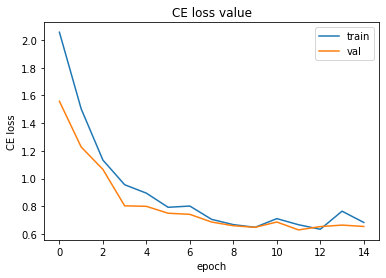

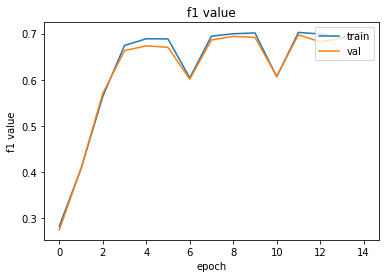

In [42]:
params['lstm_size'] = 250
params['out_conv'] = 250
params['dropout_rate'] = 0.25
params['multiple_conv_layers'] = False
params['emb_dropout'] = True
params['lstm_output_dropout'] = True
params['single_kernel'] = 2
params['multiple_kernel'] = [2, 3, 4]
params['weight_decay'] = 0.0001
params['l_r'] = 0.01
params['n_epochs'] = 15
params['path2weights'] = False

play_exp(params)

Поменяю кернел обратно на 3. Хуже чем с 2 и много фильтров


starting Epoch 0
Training...
Train loss: 2.990441423196059
Train loss: 2.355690832491274
Train loss: 2.078293593918405
Train loss: 1.946197386221452
Train loss: 1.854921729668327

Evaluating on train...
Val loss: 1.3960568819727217, Val f1: 0.3911830484867096
Val loss: 1.387612589768001, Val f1: 0.3999721109867096
Val loss: 1.3908439590817405, Val f1: 0.3988095223903656
Val loss: 1.3883214443922043, Val f1: 0.3999721109867096
Val loss: 1.3891274877956936, Val f1: 0.39893972873687744

Evaluating on test...
Val loss: 1.3710603316624959, Val f1: 0.40234375
Val loss: 1.3668763438860576, Val f1: 0.4166666865348816
Val loss: 1.372725036409166, Val f1: 0.4157986044883728
Val loss: 1.3855403264363606, Val f1: 0.4055989682674408
Val loss: 1.3776117404301962, Val f1: 0.40703126788139343
Val loss: 1.3879028227594163, Val f1: 0.40318602323532104

starting Epoch 1
Training...
Train loss: 1.6351698545309215
Train loss: 1.6101240007965654
Train loss: 1.5208913291372903
Train loss: 1.4372256539084696

Val loss: 0.6340007384618124, Val f1: 0.6488715410232544
Val loss: 0.6490340431531271, Val f1: 0.6416015625
Val loss: 0.6428295294443767, Val f1: 0.643750011920929
Val loss: 0.6499745117293464, Val f1: 0.6388502717018127

starting Epoch 10
Training...
Train loss: 1.1126727003317614
Train loss: 0.959495535603276
Train loss: 0.8591219041405654
Train loss: 0.8029451857913624
Train loss: 0.7726087440615115

Evaluating on train...
Val loss: 0.6259089197431292, Val f1: 0.701729953289032
Val loss: 0.6290749290159771, Val f1: 0.6986607313156128
Val loss: 0.6274745875880832, Val f1: 0.7020089626312256
Val loss: 0.6260989287069866, Val f1: 0.7020089626312256
Val loss: 0.6262604066303799, Val f1: 0.7030134201049805

Evaluating on test...
Val loss: 0.6609987219174703, Val f1: 0.6848958730697632
Val loss: 0.6281226774056753, Val f1: 0.7018229365348816
Val loss: 0.6411569979455736, Val f1: 0.6970486044883728
Val loss: 0.6546843747297922, Val f1: 0.6936849355697632
Val loss: 0.6509260574976603, Val f

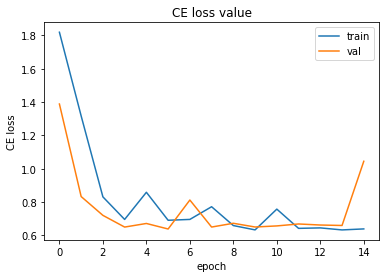

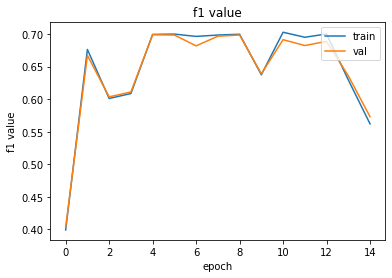

In [43]:
params['lstm_size'] = 250
params['out_conv'] = 250
params['dropout_rate'] = 0.25
params['multiple_conv_layers'] = False
params['emb_dropout'] = True
params['lstm_output_dropout'] = True
params['single_kernel'] = 3
params['multiple_kernel'] = [2, 3, 4]
params['weight_decay'] = 0.0001
params['l_r'] = 0.01
params['n_epochs'] = 15
params['path2weights'] = False

play_exp(params)

Поменяю кернел на 4 -> неровнее график, но конец хороший


starting Epoch 0
Training...
Train loss: 4.027747255105239
Train loss: 2.845098888432538
Train loss: 2.5046627492439457
Train loss: 2.279418275573037
Train loss: 2.0905220664065816

Evaluating on train...
Val loss: 1.1644319295883179, Val f1: 0.65234375
Val loss: 1.175548642873764, Val f1: 0.6496931314468384
Val loss: 1.159782507589885, Val f1: 0.6537388563156128
Val loss: 1.161012701690197, Val f1: 0.6544364094734192
Val loss: 1.1610901074750082, Val f1: 0.6540178656578064

Evaluating on test...
Val loss: 1.1365615924199421, Val f1: 0.6536458730697632
Val loss: 1.1370006203651428, Val f1: 0.666015625
Val loss: 1.149551683002048, Val f1: 0.6566840410232544
Val loss: 1.161276638507843, Val f1: 0.65234375
Val loss: 1.1559371630350748, Val f1: 0.6518229246139526
Val loss: 1.1620128220982022, Val f1: 0.6507552862167358

starting Epoch 1
Training...
Train loss: 1.2062461742988
Train loss: 1.0881493201962225
Train loss: 1.0853619706339952
Train loss: 1.0624502084471963
Train loss: 1.1145672

Val loss: 0.6502893269062042, Val f1: 0.6891276240348816
Val loss: 0.6453115502993266, Val f1: 0.686718761920929
Val loss: 0.6495891809463501, Val f1: 0.6862048506736755

starting Epoch 10
Training...
Train loss: 0.7008860982381381
Train loss: 0.6711902795014558
Train loss: 0.6629214563020845
Train loss: 0.6663280183618719
Train loss: 0.6660476361495861

Evaluating on train...
Val loss: 0.6416020733969552, Val f1: 0.691964328289032
Val loss: 0.6313789827483041, Val f1: 0.6943359971046448
Val loss: 0.6314493744146257, Val f1: 0.6964285969734192
Val loss: 0.6308654759611402, Val f1: 0.6970564126968384
Val loss: 0.6360621852534157, Val f1: 0.6954241394996643

Evaluating on test...
Val loss: 0.6611175537109375, Val f1: 0.6796875
Val loss: 0.6537934243679047, Val f1: 0.6920573115348816
Val loss: 0.6572436094284058, Val f1: 0.6888020634651184
Val loss: 0.6700665503740311, Val f1: 0.6842448115348816
Val loss: 0.6655324339866638, Val f1: 0.6830729246139526
Val loss: 0.6713542441527048, Val f1:

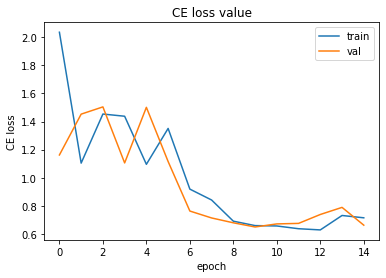

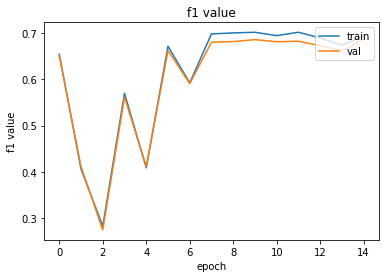

In [47]:
params['lstm_size'] = 250
params['out_conv'] = 250
params['dropout_rate'] = 0.25
params['multiple_conv_layers'] = False
params['emb_dropout'] = True
params['lstm_output_dropout'] = True
params['single_kernel'] = 4
params['multiple_kernel'] = [2, 3, 4]
params['weight_decay'] = 0.0001
params['l_r'] = 0.01
params['n_epochs'] = 15
params['path2weights'] = False

play_exp(params)

Добавлю слоев cnn. Хуже. На 250 вход не хватает 8гб видеопамяти :(


starting Epoch 0
Training...
Train loss: 3.7294067786290097
Train loss: 2.6613352122130216
Train loss: 2.2905155362152474
Train loss: 2.060984971306541
Train loss: 1.9210161851800007

Evaluating on train...
Val loss: 1.257536462375096, Val f1: 0.6579241156578064
Val loss: 1.2530043295451574, Val f1: 0.6563895344734192
Val loss: 1.2514591302190508, Val f1: 0.6573660969734192
Val loss: 1.2508806735277176, Val f1: 0.6565290689468384
Val loss: 1.2566764950752258, Val f1: 0.6553571224212646

Evaluating on test...
Val loss: 1.2366984685262044, Val f1: 0.6575521230697632
Val loss: 1.2437664071718852, Val f1: 0.6627604365348816
Val loss: 1.2564226124021742, Val f1: 0.6566840410232544
Val loss: 1.263014982144038, Val f1: 0.6529948115348816
Val loss: 1.2604629039764403, Val f1: 0.6502604484558105
Val loss: 1.2648200790087383, Val f1: 0.650104284286499

starting Epoch 1
Training...
Train loss: 1.3966973378108098
Train loss: 1.2928316328260634
Train loss: 1.2234363962964314
Train loss: 1.18113685

Val loss: 0.6803804337978363, Val f1: 0.6946614980697632
Val loss: 0.6876258518960741, Val f1: 0.6909722089767456
Val loss: 0.7005345324675242, Val f1: 0.6878255605697632
Val loss: 0.699673577149709, Val f1: 0.6861979365348816
Val loss: 0.7059062884913551, Val f1: 0.6855171322822571

starting Epoch 10
Training...
Train loss: 0.7134475983106173
Train loss: 0.6802939154483654
Train loss: 0.6804903280444261
Train loss: 0.6776668570258401
Train loss: 0.6766540935074074

Evaluating on train...
Val loss: 0.6186963617801666, Val f1: 0.7061942219734192
Val loss: 0.6144479704754693, Val f1: 0.7052176594734192
Val loss: 0.6186538750217074, Val f1: 0.7024739980697632
Val loss: 0.6196189714329583, Val f1: 0.7010324001312256
Val loss: 0.6193841823509761, Val f1: 0.7002789974212646

Evaluating on test...
Val loss: 0.6520668665568033, Val f1: 0.6927083730697632
Val loss: 0.6305849850177765, Val f1: 0.7076823115348816
Val loss: 0.639032867219713, Val f1: 0.7044270634651184
Val loss: 0.6551196972529093

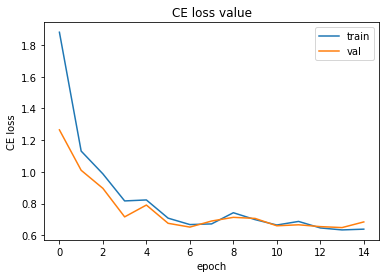

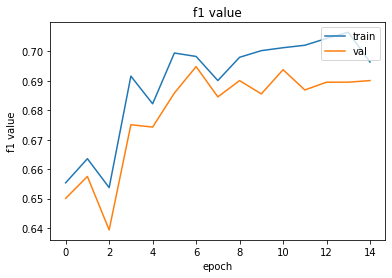

In [37]:
params['lstm_size'] = 200
params['out_conv'] = 200
params['dropout_rate'] = 0.25
params['multiple_conv_layers'] = True
params['emb_dropout'] = True
params['lstm_output_dropout'] = True
params['single_kernel'] = 3
params['multiple_kernel'] = [2, 3, 4]
params['weight_decay'] = 0.0001
params['l_r'] = 0.01
params['n_epochs'] = 15
params['path2weights'] = False

play_exp(params)

Добавлю 2 и 4-грам слои


starting Epoch 0
Training...
Train loss: 3.425849566092858
Train loss: 2.4421787526872425
Train loss: 2.1370699173066674
Train loss: 1.9762718092311513
Train loss: 1.863810152247332

Evaluating on train...
Val loss: 1.3503394297191076, Val f1: 0.3939732313156128
Val loss: 1.3480609016759055, Val f1: 0.3941127359867096
Val loss: 1.3490533488137382, Val f1: 0.3939732313156128
Val loss: 1.3486294810261046, Val f1: 0.3956473469734192
Val loss: 1.3487135205950056, Val f1: 0.3976004421710968

Evaluating on test...
Val loss: 1.3348579406738281, Val f1: 0.4010416865348816
Val loss: 1.331616183121999, Val f1: 0.4140625
Val loss: 1.337595476044549, Val f1: 0.4157986044883728
Val loss: 1.349411318699519, Val f1: 0.4039713740348816
Val loss: 1.343085225423177, Val f1: 0.40677085518836975
Val loss: 1.3487684726715088, Val f1: 0.4032227098941803

starting Epoch 1
Training...
Train loss: 1.4528981447219849
Train loss: 1.3571336931652493
Train loss: 1.3975366761044759
Train loss: 1.4107795823704112
T

Val loss: 0.6546931796603732, Val f1: 0.7035590410232544
Val loss: 0.6691525479157766, Val f1: 0.6979166865348816
Val loss: 0.6676286896069844, Val f1: 0.694531261920929
Val loss: 0.6761795481046041, Val f1: 0.6935099959373474

starting Epoch 10
Training...
Train loss: 0.6795429312265836
Train loss: 0.654249679159235
Train loss: 0.6511123020474504
Train loss: 0.6440720677375793
Train loss: 0.641056055608003

Evaluating on train...
Val loss: 0.6070609624896731, Val f1: 0.7120535969734192
Val loss: 0.6029943536434855, Val f1: 0.7089844346046448
Val loss: 0.6047900170087814, Val f1: 0.7051711678504944
Val loss: 0.6077936584396022, Val f1: 0.704659640789032
Val loss: 0.6088049688509533, Val f1: 0.7045201063156128

Evaluating on test...
Val loss: 0.6530983050664266, Val f1: 0.6731771230697632
Val loss: 0.6328679919242859, Val f1: 0.69140625
Val loss: 0.6408506830533346, Val f1: 0.6883680820465088
Val loss: 0.6539444476366043, Val f1: 0.6842448115348816
Val loss: 0.652243415514628, Val f1: 0

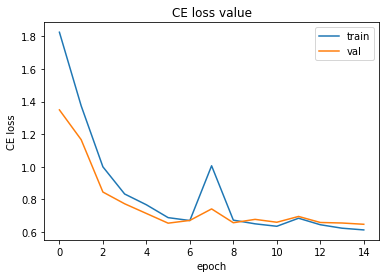

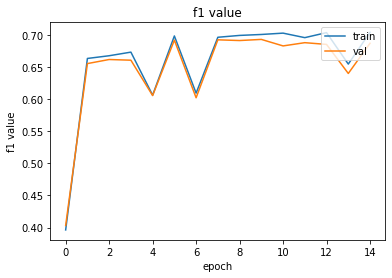

In [38]:
params['lstm_size'] = 200
params['out_conv'] = 200
params['dropout_rate'] = 0.25
params['multiple_conv_layers'] = True
params['emb_dropout'] = True
params['lstm_output_dropout'] = True
params['single_kernel'] = 3
params['multiple_kernel'] = [2, 4]
params['weight_decay'] = 0.0001
params['l_r'] = 0.01
params['n_epochs'] = 15
params['path2weights'] = False

play_exp(params)

Теперь кернелы 2-3


starting Epoch 0
Training...
Train loss: 3.0119911157167873
Train loss: 2.3951081743946783
Train loss: 2.1883299990398126
Train loss: 2.0312868790193037
Train loss: 1.9384856776914734

Evaluating on train...
Val loss: 1.630158007144928, Val f1: 0.2751116156578064
Val loss: 1.627987312419074, Val f1: 0.2829241156578064
Val loss: 1.6277005331856864, Val f1: 0.2846912145614624
Val loss: 1.6285540333815984, Val f1: 0.2837611734867096
Val loss: 1.6275338241032191, Val f1: 0.2848772406578064

Evaluating on test...
Val loss: 1.6136212746302288, Val f1: 0.2747395932674408
Val loss: 1.6279190580050151, Val f1: 0.2721354365348816
Val loss: 1.6319671471913655, Val f1: 0.2669270932674408
Val loss: 1.6290286183357239, Val f1: 0.2740885615348816
Val loss: 1.627133806546529, Val f1: 0.27135416865348816
Val loss: 1.6273636751704745, Val f1: 0.27451860904693604

starting Epoch 1
Training...
Train loss: 1.694624240581806
Train loss: 1.5943417372526947
Train loss: 1.4565303587332004
Train loss: 1.354280

Val loss: 0.6094980239868164, Val f1: 0.7018229365348816
Val loss: 0.6228219469388326, Val f1: 0.6974826455116272
Val loss: 0.6408596287171046, Val f1: 0.6936849355697632
Val loss: 0.6376776695251465, Val f1: 0.6911458969116211
Val loss: 0.6444205509291755, Val f1: 0.6903281211853027

starting Epoch 10
Training...
Train loss: 0.6578011833704435
Train loss: 0.6363953351974487
Train loss: 0.6267634383062037
Train loss: 0.629158184745095
Train loss: 0.6334429901579152

Evaluating on train...
Val loss: 0.6194929778575897, Val f1: 0.619140625
Val loss: 0.6316474910293307, Val f1: 0.6183035969734192
Val loss: 0.624520792847588, Val f1: 0.6226748824119568
Val loss: 0.6230913837041173, Val f1: 0.623046875
Val loss: 0.6227146676608495, Val f1: 0.6229352951049805

Evaluating on test...
Val loss: 0.6446649034818014, Val f1: 0.62109375
Val loss: 0.6219042539596558, Val f1: 0.62890625
Val loss: 0.6292321483294169, Val f1: 0.6263020634651184
Val loss: 0.6469171345233917, Val f1: 0.6178385615348816
V

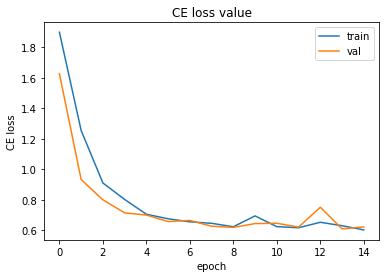

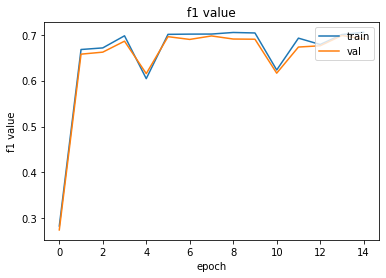

In [94]:
params['lstm_size'] = 200
params['out_conv'] = 200
params['dropout_rate'] = 0.25
params['multiple_conv_layers'] = True
params['emb_dropout'] = True
params['lstm_output_dropout'] = True
params['single_kernel'] = 3
params['multiple_kernel'] = [2, 3]
params['weight_decay'] = 0.0001
params['l_r'] = 0.01
params['n_epochs'] = 15
params['path2weights'] = False

play_exp(params)

Добавлю 3-4грам слои. Хуже


starting Epoch 0
Training...
Train loss: 2.747274930660541
Train loss: 2.2149721604806407
Train loss: 2.003355671719807
Train loss: 1.8751951326023448
Train loss: 1.7577292642731597

Evaluating on train...
Val loss: 1.0400467940739222, Val f1: 0.6545759439468384
Val loss: 1.0270893148013525, Val f1: 0.6637834906578064
Val loss: 1.0240282529876346, Val f1: 0.6632254719734192
Val loss: 1.0290078052452631, Val f1: 0.6595982313156128
Val loss: 1.034332765851702, Val f1: 0.6573102474212646

Evaluating on test...
Val loss: 1.020466427008311, Val f1: 0.6614583730697632
Val loss: 1.024779349565506, Val f1: 0.6653646230697632
Val loss: 1.0367674628893535, Val f1: 0.6566840410232544
Val loss: 1.0455075651407242, Val f1: 0.6526693105697632
Val loss: 1.0422195553779603, Val f1: 0.6510416865348816
Val loss: 1.0474980804655287, Val f1: 0.6507552862167358

starting Epoch 1
Training...
Train loss: 1.1864252915749183
Train loss: 1.0810539303002533
Train loss: 1.0221122488742922
Train loss: 1.017311475

Val loss: 0.7507739994261, Val f1: 0.6783854365348816
Val loss: 0.764351561665535, Val f1: 0.6722005605697632
Val loss: 0.7638554692268371, Val f1: 0.6716146469116211
Val loss: 0.7679665187994639, Val f1: 0.6710842251777649

starting Epoch 10
Training...
Train loss: 0.7071181031373831
Train loss: 0.6749695848535608
Train loss: 0.6776440347113261
Train loss: 0.6744473619894548
Train loss: 0.6718645640041517

Evaluating on train...
Val loss: 0.6392193564346859, Val f1: 0.7003348469734192
Val loss: 0.6342820993491581, Val f1: 0.7035435438156128
Val loss: 0.640231844924745, Val f1: 0.700985848903656
Val loss: 0.6409315658467156, Val f1: 0.6994280219078064
Val loss: 0.6424506706850869, Val f1: 0.6998884081840515

Evaluating on test...
Val loss: 0.6523258686065674, Val f1: 0.6966146230697632
Val loss: 0.6586437920729319, Val f1: 0.7044271230697632
Val loss: 0.6616467171245151, Val f1: 0.703125
Val loss: 0.6742996921141943, Val f1: 0.6979166865348816
Val loss: 0.6766318241755168, Val f1: 0.69

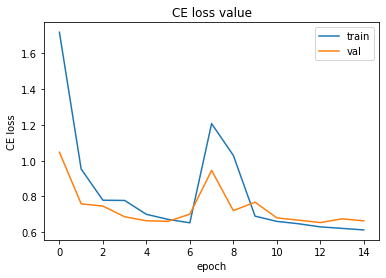

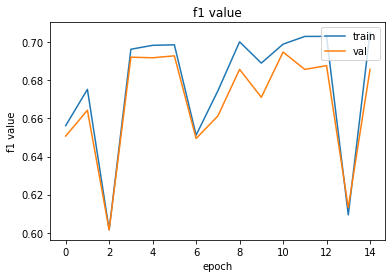

In [49]:
params['lstm_size'] = 200
params['out_conv'] = 200
params['dropout_rate'] = 0.25
params['multiple_conv_layers'] = True
params['emb_dropout'] = True
params['lstm_output_dropout'] = True
params['single_kernel'] = 3
params['multiple_kernel'] = [3, 4]
params['weight_decay'] = 0.0001
params['l_r'] = 0.01
params['n_epochs'] = 15
params['path2weights'] = False

play_exp(params)

Попробую улучшить лучший результат, уменьшив регуляризацию


starting Epoch 0
Training...
Train loss: 3.754157680731553
Train loss: 2.6784001632973
Train loss: 2.3093001958800525
Train loss: 2.1189323035153476
Train loss: 2.0031004556711167

Evaluating on train...
Val loss: 1.498075544834137, Val f1: 0.4015067219734192
Val loss: 1.4924545756408147, Val f1: 0.4089006781578064
Val loss: 1.5089381223633176, Val f1: 0.4021577537059784
Val loss: 1.507254985826356, Val f1: 0.4046456515789032
Val loss: 1.514266744681767, Val f1: 0.4017857313156128

Evaluating on test...
Val loss: 1.500378966331482, Val f1: 0.41015625
Val loss: 1.487455705801646, Val f1: 0.4205729365348816
Val loss: 1.4943855735990736, Val f1: 0.4210069477558136
Val loss: 1.5107348759969075, Val f1: 0.4098307490348816
Val loss: 1.507572881380717, Val f1: 0.4101562798023224
Val loss: 1.5135971109072368, Val f1: 0.40600720047950745

starting Epoch 1
Training...
Train loss: 1.643428894189688
Train loss: 1.5751981249562017
Train loss: 1.5163142128688534
Train loss: 1.4460870721123436
Train

Val loss: 0.6480899188253615, Val f1: 0.6961805820465088
Val loss: 0.6609830806652705, Val f1: 0.6920573115348816
Val loss: 0.6573401729265849, Val f1: 0.6898437738418579
Val loss: 0.6604684591293335, Val f1: 0.6895334124565125

starting Epoch 10
Training...
Train loss: 0.7033577882326566
Train loss: 0.6803149227742795
Train loss: 0.6907837638040868
Train loss: 0.6791799556125294
Train loss: 0.6797784238621809

Evaluating on train...
Val loss: 0.6126941655363355, Val f1: 0.7014509439468384
Val loss: 0.6179286731140954, Val f1: 0.699776828289032
Val loss: 0.6185187356812614, Val f1: 0.701729953289032
Val loss: 0.6163705140352249, Val f1: 0.7025669813156128
Val loss: 0.6149790891579219, Val f1: 0.7033482193946838

Evaluating on test...
Val loss: 0.6414278944333395, Val f1: 0.6822916865348816
Val loss: 0.6242645482222239, Val f1: 0.7005208730697632
Val loss: 0.6335890028211806, Val f1: 0.6961805820465088
Val loss: 0.6485125869512558, Val f1: 0.69140625
Val loss: 0.6461939851442973, Val f1

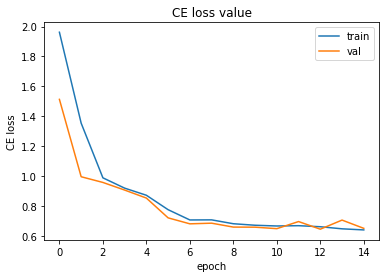

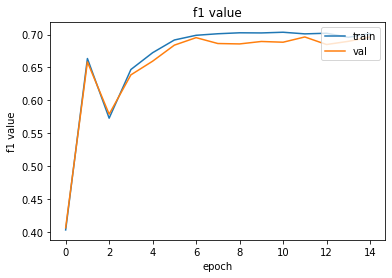

In [89]:
params['lstm_size'] = 250
params['out_conv'] = 250
params['dropout_rate'] = 0.25
params['multiple_conv_layers'] = False
params['emb_dropout'] = True
params['lstm_output_dropout'] = True
params['single_kernel'] = 2
params['multiple_kernel'] = [2, 3, 4]
params['weight_decay'] = 0.00001
params['l_r'] = 0.01
params['n_epochs'] = 15
params['path2weights'] = False

play_exp(params)

А тут лернинг рейт ещё уменьшу - фигня


starting Epoch 0
Training...
Train loss: 1.697667149397043
Train loss: 1.5615366962220933
Train loss: 1.5109239845741085
Train loss: 1.4930539846420288
Train loss: 1.479119478792384

Evaluating on train...
Val loss: 1.4199130364826746, Val f1: 0.4126674234867096
Val loss: 1.4255658728735787, Val f1: 0.4031808078289032
Val loss: 1.4225259167807442, Val f1: 0.4029948115348816
Val loss: 1.4221281707286835, Val f1: 0.4029017984867096
Val loss: 1.421109139919281, Val f1: 0.4069196581840515

Evaluating on test...
Val loss: 1.4091227849324544, Val f1: 0.4166666865348816
Val loss: 1.410473644733429, Val f1: 0.4225260615348816
Val loss: 1.418724086549547, Val f1: 0.4244791567325592
Val loss: 1.4264361162980397, Val f1: 0.4140625
Val loss: 1.4225147803624472, Val f1: 0.41562503576278687
Val loss: 1.4279005262586806, Val f1: 0.4110352098941803

starting Epoch 1
Training...
Train loss: 1.5200104254942675
Train loss: 1.4662492760905512
Train loss: 1.4593801760092013
Train loss: 1.448986916108565
T

Val loss: 1.0979544818401337, Val f1: 0.6057943105697632
Val loss: 1.10110870997111, Val f1: 0.6015625596046448
Val loss: 1.1061647600597806, Val f1: 0.6004417538642883

starting Epoch 10
Training...
Train loss: 1.1105845112067003
Train loss: 1.071265818896117
Train loss: 1.2346445714555137
Train loss: 1.2530164837837219
Train loss: 1.2634623664012854

Evaluating on train...
Val loss: 1.2702943682670593, Val f1: 0.4422433376312256
Val loss: 1.274980481181826, Val f1: 0.4419642984867096
Val loss: 1.2704958007449196, Val f1: 0.4447544813156128
Val loss: 1.2718752665179116, Val f1: 0.443638414144516
Val loss: 1.2789066927773611, Val f1: 0.43950894474983215

Evaluating on test...
Val loss: 1.3297393719355266, Val f1: 0.4270833432674408
Val loss: 1.3117783069610596, Val f1: 0.4388020932674408
Val loss: 1.3145066897074382, Val f1: 0.440972238779068
Val loss: 1.3308692077795665, Val f1: 0.4296875
Val loss: 1.3231862465540567, Val f1: 0.43307292461395264
Val loss: 1.325077560212877, Val f1: 0.

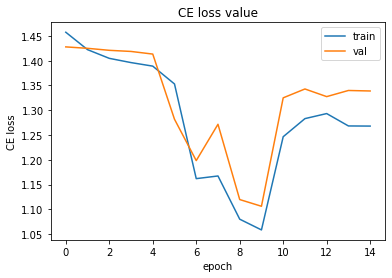

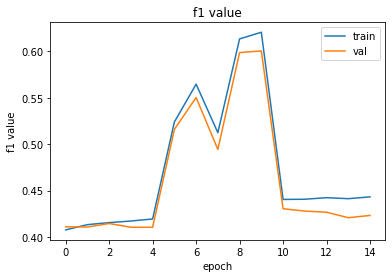

In [90]:
params['lstm_size'] = 250
params['out_conv'] = 250
params['dropout_rate'] = 0.25
params['multiple_conv_layers'] = False
params['emb_dropout'] = True
params['lstm_output_dropout'] = True
params['single_kernel'] = 2
params['multiple_kernel'] = [2, 3, 4]
params['weight_decay'] = 0.00001
params['l_r'] = 0.001
params['n_epochs'] = 15
params['path2weights'] = False

play_exp(params)

Я бы мог нарисовать графики и подобное, но результаты настолько схожи, что не особо вижу смысла. + перезапускать предется все, а это будет долго + слишком много параметров и экспериментов. Поэтому лучше выскажу основные идеи словами:
* У авторов статьи была очень большая регуляризация, нужно хотя бы в 10 раз меньше, сильно влияет на результаты.
* Не влияют особо такие параметры, как количество фильтров (грубо говоря 200 точно достаточно, больше для модели не надо)
* Хватит 5 эпох +-, потому что модель дальше не учиться, данные слишком плохие (нечеткое распределение по классам)
* Лучший результат показала модель с одним cnn и кернелом 2 (с 3 нет особо разницы) -> для этой задаче не нужно много свертывания - это показывают и плохие результаты с несколькими слоями.
* Собственно модель с 3 слоями показала худшие результаты, лучше всего с мультп слоями показала модель с кернелами 2 и 3 лучшие. Что подтверждает слова выше.
* Дропаут важен, но надо не переборщить + нет склонности к переобучению, скорее к взрывам градиента
* Леринг рейт лучше ставить от 0.01 до 0.005, в зависимости от кол-ва эпох и ресурсов

Вообще результаты вышли довольно схожими, можно поэксперементировать с другими эмбедингами или препроцом.

### Бонус - не совсем понял смысл, можно же найти готовые имплементации?

In [ ]:
import math
import torch as th
import torch.nn as nn

class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.i2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden):
        h, c = hidden
        h = h.view(h.size(1), -1)
        c = c.view(c.size(1), -1)
        x = x.view(x.size(1), -1)

        # Linear mappings
        preact = self.i2h(x) + self.h2h(h)

        # activations
        gates = preact[:, :3 * self.hidden_size].sigmoid()
        g_t = preact[:, 3 * self.hidden_size:].tanh()
        i_t = gates[:, :self.hidden_size]
        f_t = gates[:, self.hidden_size:2 * self.hidden_size]
        o_t = gates[:, -self.hidden_size:]

        c_t = th.mul(c, f_t) + th.mul(i_t, g_t)

        h_t = th.mul(o_t, c_t.tanh())

        h_t = h_t.view(1, h_t.size(0), -1)
        c_t = c_t.view(1, c_t.size(0), -1)
        return h_t, (h_t, c_t)

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.in2output = nn.Linear(input_size + hidden_size, output_size)
    
    def forward(self, x, hidden_state):
        combined = torch.cat((x, hidden_state), 1)
        hidden = torch.sigmoid(self.in2hidden(combined))
        output = self.in2output(combined)
        return output, hidden
    
    def init_hidden(self):
        return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, num_layers, hidden_size):
        super(GRUModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(
            input_size=num_letters, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
        )
        self.fc = nn.Linear(hidden_size, num_langs)
    
    def forward(self, x):
        hidden_state = self.init_hidden()
        output, hidden_state = self.gru(x, hidden_state)
        output = self.fc(output[-1])
        return output
    
    def init_hidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size).to(device)